# Atelier DAY 2 :  prévision de courbes de charge de consommation électrique

L’objectif de cet atelier est de construire un modèle afin de prévoir la courbe de charge de la consommation électrique d'un site, avec les contraintes suivantes : 
           
 - on souhaite une prédiction sur 3 jours
 - avec un intervalle d'1 jour par rapport à l'historique des données. 

Par exemple, les observations sur le site ID08 - hôtel ou hébergement similaire - s'arrêtent le 09/10/2012 à 23:30. Il s'agit donc de prévoir la courbe de charge de consommation pour les 11/10/2012, 12/10/2012 et 13/10/2012. 

L’atelier est scindé en 2 étapes :

* **Étape 1**. Pré-traitement des données. 
Cette étape contient :

    - L’import et l’audit des données : vérification rapide du contenu des fichiers de travail. Permet d’avoir une idée des méthodologies possibles à utiliser. 

    - Mise au format des données. En effet, pour étudier cette série temporelle, il va falloir découper les données en périodes (d'une durée à fixer) dont on va observer des réplicats (dans le temps).
    
* **Étape 2**. Modélisation : apprentissage et test. 
Plusieurs modélisations sont proposées :

    - Régression linéaire
    - Gradient Boosting : LightGBM
    - Random Forest


<a id='import'></a>
# Importer et auditer les données 

Les données à disposition sont contenues dans le fichier  `Courbes_Charge08.csv` à charger et qui contient 

   - la consommation d'éléctricité relevée toutes les 10 minutes sur le site ID08  
   - la température sur le site ID08 relevée physiquement toutes les 3 heures. Les données sur les temps intermédiaires ont été complétées par interpolation linéaire. 

Le format du fichier est le suivant: 

In [1]:
# Ci-dessous une commande pour afficher (hors python) les dix premières lignes du fichier et visualiser sa structure

In [2]:
%%bash
head -10 'data/Courbes_Charge08.csv'

DATE_LOCAL;Charge_ID08;Temp_ID08
01/01/2011 00:00;205;-0,7
01/01/2011 00:10;212;-0,716666667
01/01/2011 00:20;195;-0,733333333
01/01/2011 00:30;188;-0,75
01/01/2011 00:40;190;-0,766666667
01/01/2011 00:50;184;-0,783333333
01/01/2011 01:00;180;-0,8
01/01/2011 01:10;180;-0,816666667
01/01/2011 01:20;178;-0,833333333


### Exercice 1

Importez les données dans un dataframe (de la bibliothèque `pandas`) nommé `df` : 
* L'option `parse_dates` de la fonction `read_csv` de pandas vous permet de lire correctement la variable de date ;  
* Faites attention au format de la température. 
* On transformera les noms de variables en minuscules (usage python). 

Puis familiarisez-vous avec ces données (à l'aide de shape, head, dtypes, describe,...). Pendant combien de jours sont mesurées les données du site ? 


À l'aide de la librairie `matplotlib`, tracez les courbes de charge et de température en fonction de la date. Zoomez la courbe de charge en faisant varier la date de début et la durée de l'observation (pour mémoire, 1 jour = 6x24 points), l'objectif étant de comprendre les périodicités de cette courbe.  

In [3]:
# Your answer

### Réponse

In [1]:
import os
import numpy as np
import pandas as pd

# Votre chemin. Par defaut celui du notebook
# path_data = '.'
path_data = 'data/'
    
df = pd.read_csv(os.path.join(path_data, 'Courbes_Charge08.csv'), sep=';', 
                 parse_dates=['DATE_LOCAL'],
                 decimal=',',  # les décimales sont codées par une virgule
                 dayfirst=True, # the day appears before month
                 infer_datetime_format=True)

# L'usage en Python est de mettre les noms de variables en minuscule 
df.columns = [x.lower() for x in df.columns]

In [2]:
df.head()

,date_local,charge_id08,temp_id08
0,2011-01-01 00:00:00,205,-0.700000
1,2011-01-01 00:10:00,212,-0.716667
2,2011-01-01 00:20:00,195,-0.733333
3,2011-01-01 00:30:00,188,-0.750000
4,2011-01-01 00:40:00,190,-0.766667


In [6]:
df.tail()

,date_local,charge_id08,temp_id08
93307,2012-10-09 23:10:00,83,15.061111
93308,2012-10-09 23:20:00,82,14.988889
93309,2012-10-09 23:30:00,76,14.916667
93310,2012-10-09 23:40:00,81,14.844444
93311,2012-10-09 23:50:00,54,14.772222


Les données du site id08 débutent le 1er janvier 2011 à minuit et s'achèvent le 09 octobre 2012 à 23:50. Elles sont régulières et contiennent des mesures toutes les 10 minutes. 


In [7]:
df.shape

(93312, 3)

Avec des mesures toutes les 10 mins, on doit avoir 6 mesures par heure et 6*24 mesures par jour. Les 93312 lignes correspondent donc à 648 jours, ce qui fait bien 1 an (365 jours) plus 283 jours ; soit 1 an, 40 semaines et 3 jours.  

In [8]:
df.dtypes

date_local     datetime64[ns]
charge_id08             int64
temp_id08             float64
dtype: object

In [9]:
df.columns

Index(['date_local', 'charge_id08', 'temp_id08'], dtype='object')

In [10]:
df.describe()

,charge_id08,temp_id08
count,93312.000000,93312.000000
mean,71.723615,11.696754
std,29.776986,5.731311
min,21.000000,-8.700000
25%,49.000000,7.944444
50%,62.000000,11.733333
75%,88.000000,15.722222
max,260.000000,31.500000


In [11]:
# description IT des données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93312 entries, 0 to 93311
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_local   93312 non-null  datetime64[ns]
 1   charge_id08  93312 non-null  int64         
 2   temp_id08    93312 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB


On trace les courbes de charge et de température en fonction de la date : 

<AxesSubplot:xlabel='date_local'>

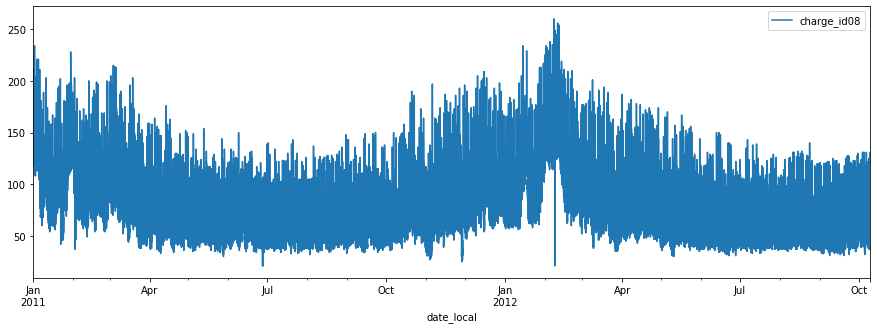

In [13]:
from matplotlib import pyplot as plt

%matplotlib inline

df.plot(x='date_local', y='charge_id08', figsize=(15, 5))

<AxesSubplot:xlabel='date_local'>

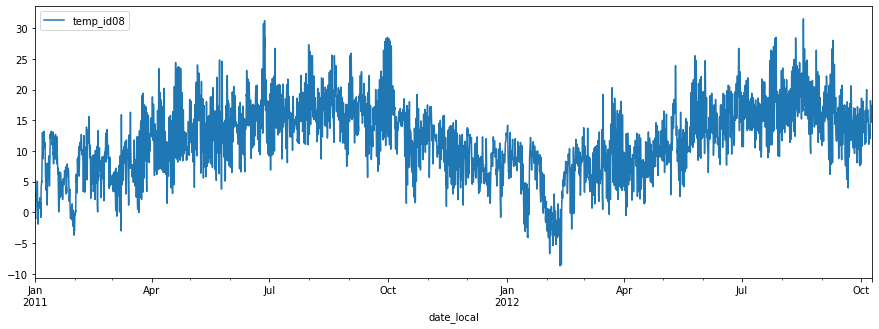

In [13]:
df.plot(x='date_local', y='temp_id08', figsize=(15, 5))

Nous allons zoomer les courbes de charge en faisant varier la date de départ et la durée des périodes (rappel 1 jour = 6*24 points), l'objectif étant de comprendre les périodicités de cette courbe.

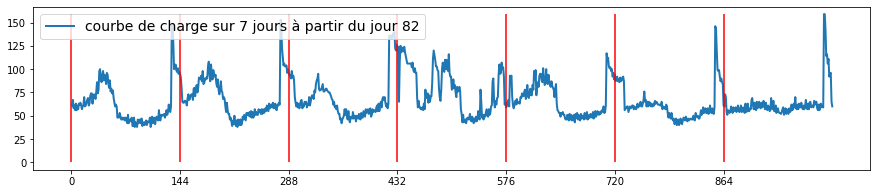

In [14]:
# On fera varier les deux quantités ci-dessous
j_deb = 82 # n'importe quoi entre 0 et 648 moins la durée d'observation
j_dur = 7 # regardons sur une semaine de temps

# 
debut = 6*24*j_deb # point de départ 
duree = 6*24*j_dur
fig = plt.figure(figsize=(15, 3))
x = np.linspace(1, duree, duree)
plt.plot(x, df["charge_id08"].iloc[debut:(debut+duree)], label="courbe de charge sur %.f jours à partir du jour %.f" %(j_dur, j_deb), lw=2)
# séparateur de jours
plt.xticks(np.arange(0, max(x), 6*24))
plt.vlines(np.arange(0, max(x), 6*24),0,max(df["charge_id08"].iloc[debut:(debut+duree)]),color='red')
plt.legend(fontsize=14, loc='upper left')

Rappel : Une journée contient 6x24=144 points et une semaine en contient 1008. On a tracé ci-dessus les périodes quotidiennes. On voit que certains jours ont des profils identiques, mais pas tous. 

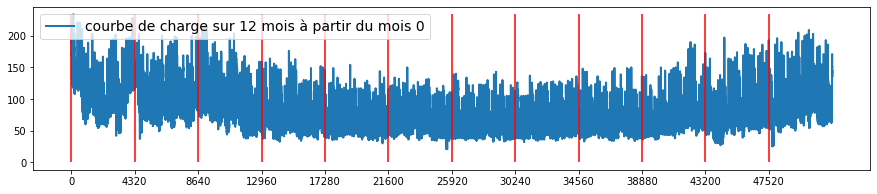

In [15]:
# On regarde les choses à l'échelle mensuelle
# On fera varier les deux quantités ci-dessous
m_deb = 0 # n'importe quoi entre 0 et 22 moins la durée d'observation
m_dur = 12 # regardons pendant un nobre de mois fixé

# On se fixe des mois à 30 jours 
debut = 6*24*30*m_deb # point de départ 
duree = 6*24*30*m_dur
fig = plt.figure(figsize=(15, 3))
x = np.linspace(1, duree, duree) 
plt.plot(x, df["charge_id08"].iloc[debut:(debut+duree)], label="courbe de charge sur %.f mois à partir du mois %.f" %(m_dur, m_deb), lw=2)
# séparateur de mois : 
plt.xticks(np.arange(0, max(x), 6*24*30)) 
plt.vlines(np.arange(0, max(x), 6*24*30),0,max(df["charge_id08"].iloc[debut:(debut+duree)]),color='red')
plt.legend(fontsize=14, loc='upper left')

Conclusion : à l'échelle mensuelle on ne voit pas grand chose (sauf peut-être l'hiver et l'été).

# Mise au format des données


## Utilisation des données calendaires

Dans cette partie, nous utilisons le module `datetime` afin de créer des champs de variables calendaires (pour une étude plus avancée). On définit donc les 3 variables suivantes : 
* identifiant de jour (de 1 à 648 sur ces données)
* type de jour (lundi, mardi,...)
* un code du type de jour (de 0 à 6 pour lundi à dimanche)


In [3]:
import datetime

# On ajoute la colonne qui donne un id unique du jour

# Pour cela on écrit une fonction qui donne le nombre exact de jours dans 
# une année donnée
def n_days_in_year(year):
    d1 = datetime.date(year, 1, 1) 
    d2 = datetime.date(year + 1, 1, 1) 
    return (d2 - d1).days

# L'année la plus ancienne dans le jeux de données
min_year = df['date_local'].dt.year.min()

# Une fonction qui renvoie un numéro unique de jour 
def day_number(t):
    n_days = 0
    for y in range(min_year, t.year):
        n_days += n_days_in_year(y)      
    return n_days + t.dayofyear

# On ajoute à notre jeu de données une colonne avec numero du jour
col_jour = df['date_local'].apply(day_number)
df.insert(loc=0, column='jour', value=col_jour)

In [4]:
# On ajoute également une colonne qui donne le nom du jour
day_name = df['date_local'].dt.day_name()
df.insert(loc=1, column='type_jour', value=day_name)

# Création de codes pour le type de jour
day_num = df['date_local'].dt.dayofweek
df.insert(loc=2, column='code_jour', value=day_num)

# Visualisons le nouveau jeu de données
df.head()

,jour,type_jour,code_jour,date_local,charge_id08,temp_id08
0,1,Saturday,5,2011-01-01 00:00:00,205,-0.700000
1,1,Saturday,5,2011-01-01 00:10:00,212,-0.716667
2,1,Saturday,5,2011-01-01 00:20:00,195,-0.733333
3,1,Saturday,5,2011-01-01 00:30:00,188,-0.750000
4,1,Saturday,5,2011-01-01 00:40:00,190,-0.766667


In [5]:
df.tail()

,jour,type_jour,code_jour,date_local,charge_id08,temp_id08
93307,648,Tuesday,1,2012-10-09 23:10:00,83,15.061111
93308,648,Tuesday,1,2012-10-09 23:20:00,82,14.988889
93309,648,Tuesday,1,2012-10-09 23:30:00,76,14.916667
93310,648,Tuesday,1,2012-10-09 23:40:00,81,14.844444
93311,648,Tuesday,1,2012-10-09 23:50:00,54,14.772222


In [18]:
df['code_jour'].unique()

array([5, 6, 0, 1, 2, 3, 4])

## Formatage de la série temporelle - Étape importante : choix de la periode

Dans cette partie, on va découper la série temporelle en série  d'observations successives sur une période fixée. Ces différentes périodes seront ensuite considérées comme des **réplicats i.i.d**. **Cath-Warning: parler de iid vraiment???** Il faut donc choisir une période qui fait du sens vis-à-vis de la variable étudiée (ici la courbe de charge). Il faudra aussi choisir une période de façon à avoir assez de réplicats (par exemple travailler à l'échelle annuelle n'est pas possible avec ces données). 

**Cath_Warning**: je voulais dire par exemple qu'un mois c'était débile, parce que tous les mois n'ont pas la même distribution ; mais si on va par là, toutes les semaines non plus...


### Exercice 2

Définissez une variable `periode`, exprimée en jours, qui pourra prendre par exemple les valeurs 1 (courbes de charge quotidiennes) ou 7 (courbes de charge hebdomadaires) ou tout autre choix. Pour cette variable, vous allez :
* définir `nobs` comme le nombre de points de mesure correspondant à cette période
* définir `n` comme le nombre **entier** de périodes contenues dans les données. 

Ensuite, vous allez :
- supprimer les données les plus anciennes de manière à avoir un nombre entier de périodes d'observation ;
- sauver le tableau de travail sous un nouveau nom `df2`.

In [19]:
# Your answer

### Réponse

In [20]:
## On fixe la periode en jours - faites varier la période
#periode = 1 # On peut travailler sur des consommations journalières
periode = 7 # Ou sur des consommations hebdomadaire

In [21]:
# Nombre de points d'observation necessaires pour 1 période (exprimée en jours)
nobs = periode * 6 * 24

# Nombre de periodes disponibles dans les donnees
n = int(df.shape[0] / nobs)

In [22]:
# On supprime des données de manière à disposer d'un nombre entier de périodes d'observation

# Nombre de lignes a supprimer (on choisit de les supprimer au debut de la période d'observation)
kill = df.shape[0] - n * nobs

# On définit un nouveau tableau en supprimant la période incomplète du début 
df2 = df.iloc[kill:df.shape[0]]

# Comptages divers
print("Chaque période contient %.f points de mesure" %nobs)
print("Il y a un total de %.f périodes" %n)
print("On a supprimé %.f points d'observation en début de série" %kill)
print("Les nouvelles données contiennent %.f points de mesure" %df2.shape[0])

Chaque période contient 1008 points de mesure
Il y a un total de 92 périodes
On a supprimé 576 points d'observation en début de série
Les nouvelles données contiennent 92736 points de mesure


In [23]:
# Visualisons l'en-tête des nouvelles données
df2.head()

,jour,type_jour,code_jour,date_local,charge_id08,temp_id08
576,5,Wednesday,2,2011-01-05 00:00:00,122,1.700000
577,5,Wednesday,2,2011-01-05 00:10:00,124,1.683333
578,5,Wednesday,2,2011-01-05 00:20:00,124,1.666667
579,5,Wednesday,2,2011-01-05 00:30:00,125,1.650000
580,5,Wednesday,2,2011-01-05 00:40:00,133,1.633333


### Exercice 3

Vous devez à présent construire un nouveau tableau de données, appelé `df_charge` qui contient autant de lignes que de points d'observations contenus dans une période (`nobs`) et dont les colonnes sont les valeurs de la charge pour une période donnée (il y a `n` périodes et donc `n` colonnes). Vous nommerez les colonnes de Cn (la première) à C1 (la dernière), les premières correspondant aux périodes les plus récentes et les dernières correspondant aux périodes les plus anciennes.

En utilisant ce nouveau tableau, tracez sur un même graphique la  superposition de quelques courbes de charge sur la période donnée.

Faites varier la période.

Faites la même chose avec la température. Vous nommerez les colonnes Tn à T1 avec la même convention.

Enfin, créez un tableau `df_CJ` d'une seule variable et de `nobs` lignes qui contient le code du jour où débute la période considérée (on utilisera la seconde colonne du tableau df défini plus haut). 

In [24]:
# Your answer

### Réponse

In [25]:
# Reformater la variable charge_id08
# C1 ==>  correspond à la charge de la période 1, C2  ==> Période 2 , etc
nom = ['C' + str(i) for i in range(2, n + 2)]
debut, fin = 0, nobs 

df_charge = df2.iloc[debut:fin, 4].to_frame()

for i in range(n - 1):
    debut += nobs
    fin += nobs
    a = df2.iloc[debut:fin, 4]
    df_charge.insert(0, nom[i], a.values) ##Cath_warning VIRER le 0

df_charge.rename(columns={'charge_id08': 'C1'}, inplace=True)

In [ ]:
# reprendre avec la commande de Vincent
# df_charge2 = np.array(df2['charge_id08']).reshape(n, nobs).T

**Cath_Warning** Quand la periode est égale à un jour, Python me dit :

PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Il faudrait ré-écrire sa boucle toute pourrie. OU alors on dit qu'on s'en fout.

In [26]:
# Le nouveau tableau a nobs lignes et n colonnes
print(df_charge.shape)
print(nobs,n)

(1008, 92)
1008 92


In [27]:
# Visualisons le haut du nouveau tableau
df_charge.head()

,C92,C91,C90,C89,C88,C87,C86,C85,C84,C83,...,C10,C9,C8,C7,C6,C5,C4,C3,C2,C1
576,62,42,72,82,87,87,103,94,90,79,...,81,141,126,124,71,93,106,100,116,122
577,43,43,72,80,88,83,110,97,86,78,...,85,115,133,120,72,105,122,108,119,124
578,51,44,71,82,84,84,107,95,85,79,...,83,113,127,120,73,94,124,91,104,124
579,45,44,72,83,88,85,107,90,82,79,...,75,111,125,120,76,97,111,100,118,125
580,50,45,71,79,87,86,112,94,80,76,...,86,100,118,118,72,94,120,105,120,133


Notez que les périodes sont ordonnées de la plus récente (première colonne, qui s'appelle Cn) à la plus ancienne (dernière colonne, qui s'appelle C1).

In [27]:
print("Il y a correspondance entre la variable C1 et la charge de la période 1")
df2.head()

Il y a correspondance entre la variable C1 et la charge de la période 1


,jour,type_jour,code_jour,date_local,charge_id08,temp_id08
576,5,Wednesday,2,2011-01-05 00:00:00,122,1.700000
577,5,Wednesday,2,2011-01-05 00:10:00,124,1.683333
578,5,Wednesday,2,2011-01-05 00:20:00,124,1.666667
579,5,Wednesday,2,2011-01-05 00:30:00,125,1.650000
580,5,Wednesday,2,2011-01-05 00:40:00,133,1.633333


Visualisons les charges de quelques périodes choisies arbitrairement.

C82 débute le : Wednesday 2012-08-01 00:00:00
C83 débute le : Wednesday 2012-08-08 00:00:00
C84 débute le : Wednesday 2012-08-15 00:00:00
C85 débute le : Wednesday 2012-08-22 00:00:00
C86 débute le : Wednesday 2012-08-29 00:00:00
C87 débute le : Wednesday 2012-09-05 00:00:00


<Figure size 1296x432 with 0 Axes>

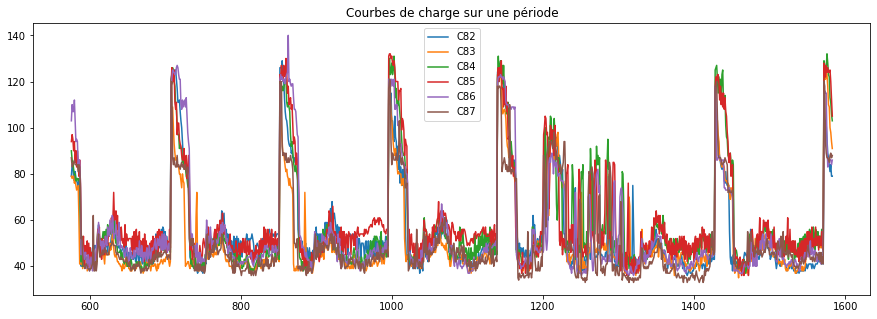

In [28]:
# Visualisation graphique de quelques périodes 
P0 = [10,9,8,7,6,5] # on choisit des indices de périodes  
# Cath_Warning : il a choisi des colonnes consécutives mais on s'en fout on prend ce qu'on veut
periodes = df_charge.columns[P0]

fig = plt.figure(figsize=(18, 6))
df_charge.plot(y=periodes, figsize=(15, 5), title='Courbes de charge sur une période')

# Cath_Warning : je voulais ajouter des lignes verticales pour séparer les jours mais ça commence pas à 0 alors ça merde
#plt.xticks(np.arange(0, df_charge.shape[0], 6*24))
#plt.vlines(np.arange(0, df_charge.shape[0], 6*24),0,max(periodes),color='black')

# Pour chaque période, on indique à quel jour de la semaine et quelle date elle débute
# CATH-Warning : pas sur que le jour soit le bon !!!
for i in range(len(periodes)): 
    a = (n - P0[i])*periode + int(kill/6/24)+1   # on démarre au jour d'indice kill/(6*24)+1
    toto = df2[df2['jour'] == a]
    print(periodes[i], 'débute le :',toto.iloc[0,1],toto.iloc[0,3])
    

On fait la même chose sur la variable température.

/Users/catherine.matias/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3364: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


T638 débute le : Sunday 2012-09-30 00:00:00
T639 débute le : Monday 2012-10-01 00:00:00
T640 débute le : Tuesday 2012-10-02 00:00:00
T641 débute le : Wednesday 2012-10-03 00:00:00
T642 débute le : Thursday 2012-10-04 00:00:00
T643 débute le : Friday 2012-10-05 00:00:00


<Figure size 1296x432 with 0 Axes>

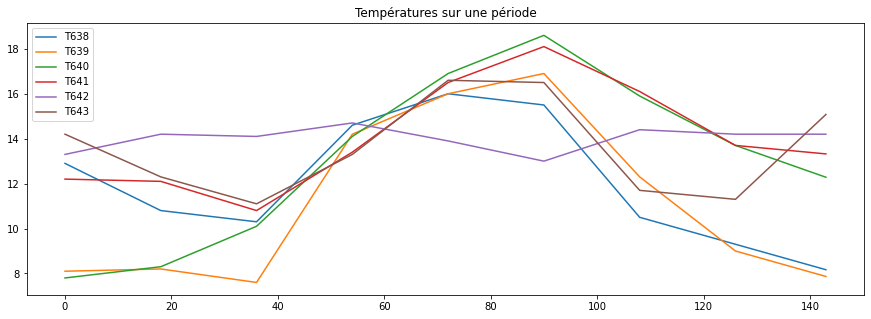

In [16]:
# Reformater la variable temp_id08
# T1 ==>  correspond à la température de la période 1, T2  ==> Période 2 , etc
nom = ['T' + str(i) for i in range(2, n + 2)]
debut, fin = 0, nobs 
df_temp = df2.iloc[debut:fin, 5].to_frame()

for i in range(n - 1):
    debut += nobs
    fin += nobs
    a = df2.iloc[debut:fin, 5]
    df_temp.insert(0, nom[i], a.values) # insère 0 insère au début!!!

df_temp.rename(columns={'temp_id08': 'T1'}, inplace=True)
df_temp.head()

# Courbes de température pour quelques périodes
P0 = [10,9,8,7,6,5]
periodes = df_temp.columns[P0]

fig = plt.figure(figsize=(18, 6))
df_temp.plot(y=periodes, figsize=(15, 5), title='Températures sur une période')

# Pour chaque période, on indique à quel jour de la semaine et quelle date elle débute

for i in range(len(periodes)):    
    a = (n - P0[i])*periode + int(kill/6/24)+1   # on démarre au jour d'indice kill/(6*24)+1
    toto = df2[df2['jour'] == a]
    print(periodes[i], 'débute le :',toto.iloc[0,1],toto.iloc[0,3])


In [18]:
# Créer une variable CJ qui code le type de jour 
# Cath-Warning : est-ce qu'on se sert de ça ???
debut, fin = 0, nobs 
df_CJ = df2.iloc[debut:fin, 2].to_frame()
df_CJ.head()

,code_jour
0,5
1,5
2,5
3,5
4,5


## Premières questions de modélisation

Nous allons apprendre la courbe de charge $C_j$ de la période numéro $j$ à l'aide des courbes de charge $C_{k}, C_{p}, \ldots$ des jours passés numéro $k,p, \ldots$.

Attention, le problème initial imposé est de proposer une prévision :
   - d'une durée 3 jours ;
   - avec un intervalle d'1 jour par rapport à l'historique des données. 
   


### Exercice 4 

1. Une modélisation "à la journée" est-t-elle judicieuse à votre avis ? Étudiez cette question : 
    -  en observant le comportement des différents types de jours ;
    -  en pensant à l'objectif : prévision sur 3 jours avec un intervalle d'1 jour.


2. Choisir de modéliser "à la semaine" plutôt qu'à la journée" ne semble-t-il pas plus pertinent ? Pourquoi ? 

3. Quelles variables explicatives pourrait-on inclure dans le modèle ?


Your answer :

### Réponse

1. Non ce n'est pas judicieux car les jours ont des comportements différents (typiquement le dimanche a un profil de courbe de charge très différent). 

2. Modéliser à la semaine est donc plus intéressant, puisque la périodicité des comportements est sur 7 jours. 

3. Il est naturel et même obligatoire d'inclure la température comme variable explicative. 


**Refaites tourner le code ci-dessus en choisissant une période de 7 jours avant de passer à la suite.** 

# Modélisation

**NB** : Pour tous les modèles proposés, il faut choisir la profondeur de l'historique selon :
- les possibilités techniques ;
- le sens "métier".

## Modèle de régression linéaire

On commence par choisir une période (ici une semaine) d'indice $k$  et par entraîner le modèle linéaire pour prévoir la courbe de charge sur la période (semaine) qui suit immédiatement la période $k$, i.e la période d'indice $k-1$. Autrement dit on va d'abord apprendre le lien entre $C_k$ et les courbes de charges précedentes $C_{k+1},C_{k+2},\dots,C_{k+h}$ ainsi que les températures associées $T_{k+1},\dots,T_{k+h}$, pour un certain choix de l'historique $h$.
**Cath-Warning: y'a un pbm de notation, il a pris soin de numéroter les colonnes à l'envers mais suivant qu'on utilise le nom Ck ou bien l'indice de colone C[k] on n'utilise pas la même chose donc c'est la merde. En fait la numérotation sert à rien, il faut la virer, et parler seulement en indices de colonnes.**
**Aussi : On va réinsérer dans le bon ordre**
Ensuite, on utilisera cette relation apprise pour prédire la courbe de charge $C_{k-1}$. On évaluera les mêmes erreurs que précedemment entre la courbe prédite et la courbe réelle. **Reprendre**

La qualité de la méthode sera évaluée en faisant varier $k$ et $h$ (selon la longueur des données dont on dispose).

### Exercice 5
**Question intermédiare - formuler**
À l'aide de la fonction `LinearRegression` du module `sklearn.linear_model` faites une régression linéaire de la variable $C_k$ (qu'on renommera en `y_train`) sur les variables $C_{k+1},\dots C_{k+h}, T_{k+1},\dots,T_{k+h}$ (qu'on renommera en `x_train`). 

Ensuite, grâce à cette relation apprise, vous prédirez la variable $C_{k-1}$ (renommée `y_test`) à partir des $h$ variables immédiatement précédentes, c'est-à-dire $C_{k},\dots C_{k+h-1},T_k,\dots, T_{k+h-1}$ (renommées `x_test`).

La qualité de la prédiction sera mesurée en erreur relative pour la norme $L_1$ ainsi que via la racine carrée de l'erreur quadratique moyenne (via la fonction `mean_squared_error` du module `sklearn.metrics`). 
**Cath_Warning: il fait du L1 relatif et du MSE absolu !**
Vous calculerez également la corrélation de Pearson entre les valeurs prédites et les valeurs observées via  la fonction `pearsonr` du module `scipy.stats`.

Vous tracerez les courbes prédites et observées pour visualiser la qualité de la prédiction. 

In [32]:
# Your answer

### Réponse

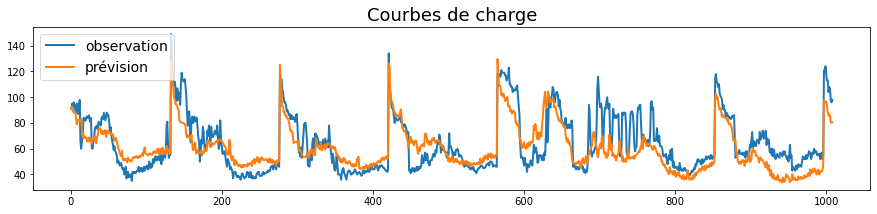

RMSE: 13.9473
MAPE: 0.1752
Correlation observation/prevision: 0.7771


In [35]:
### Modèle Auto-régressif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr 

# Choisir le numero k de periode
# Apprendre le lien entre Ck et son passe C_{k+1}...C_{k+h}, T_{k+1}...T_{k+h}
# Prevoir la periode suivante C_{k-1}

# Numero de colonne du debut la periode d'apprentissage 
k = 75
# Nombre de periodes (semaines) passées, ie historique utilisé
h = 4

# Creation du modele
lr = LinearRegression()
# Cath_Warning: il a choisi de ne pas normaliser avant de faire sa régression. 

# Données TEST et TRAIN
# NB on a rangé les colonnes des plus récentes au plus anciennes !
y_train = df_charge.iloc[:, k]
x_train = pd.concat([df_charge.iloc[:, (k+1):(k+h+1)], # courbes de charge de l'historique
                     df_temp.iloc[:, (k+1):(k+h+1)]], axis=1) # courbes de température de l'historique
y_test = df_charge.iloc[:, (k-1)]
x_test = pd.concat([df_charge.iloc[:, k:(k+h)],
                     df_temp.iloc[:, k:(k+h)]], axis=1) # nouvel historique

# Rename columns - Necessary
x_test.columns = x_train.columns

lr.fit(x_train, y_train) 
pred = lr.predict(x_test)

#############
# Graphes de prédiction sur toute la période
fig = plt.figure(figsize=(15, 3))

x = np.linspace(1, nobs, nobs)
plt.plot(x, y_test, label="observation", lw=2)
plt.plot(x, pred, label="prévision", lw=2)
plt.title('Courbes de charge', fontsize=18)
plt.legend(fontsize=14, loc='upper left')

plt.show()

# Root mean square error
rmse = mean_squared_error(y_test, pred) ** 0.5 # racine carrée de la MSE
print("RMSE: %.4f" % rmse)
# Mean absolute prediction error
mape = (abs((pred - y_test) / y_test)).mean()
print("MAPE: %.4f" % mape)
cor = pearsonr(y_test, pred)
print("Correlation observation/prevision: %.4f" % cor[0])

Notez que le problème des mesures RMSE et MAP est qu'elles ne sont pas facilement interprétables (combien vaut un 'bon RMSE' ?). Il faut faire varier les valeurs de $h$ et de $k$ (c'est ce qu'on fera ci-dessous) pour trouver le 'meilleur' ajustement.  
**Cath_warning : en plus son erreur L1 elle est relative et pas l'autre donc y'a un gros pbm d'échelle. Ajouter du L2 relatif. Worst-case ou mean-value??? Sensibiliser au choix de l'utilisateur.**


### Exercice 6

Avec cette approche, répondez à la demande initiale de prédiction sur 3 jours avec un intervalle d'un jour. Plus précisément, grâce à la relation apprise ci-dessus entre la courbe de la semaine $k$ et celles des $h$ semaines précédentes, vous avez obtenu une prédiction pour la semaine $k-1$ et vous pouvez en extraire les prédictions pour les jours numéros 2 à 4 de cette semaine. Vous tracerez les courbes prédites et observées et calculerez les mêmes erreurs que précédemment.

In [34]:
# Your answer

### Réponse

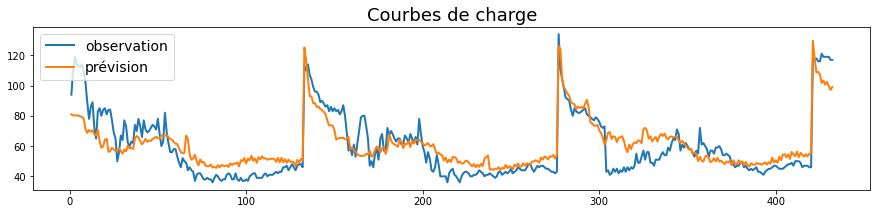

RMSE: 11.0439
MAPE: 0.1570
Correlation observation/prevue: 0.8636


In [36]:
# Prédiction demandée : 3 jours avec un intervalle de 1 jour ==> restriction

gap = 1
horizon = 3 
debut = gap * 6 * 24 # première mesure (commence le second jour de la période)
fin = debut + horizon * 6 * 24 # dernière mesure (finit le quatrième jour de la période)

fig = plt.figure(figsize=(15, 3))

npoints = fin-debut
x = np.linspace(1, npoints,npoints)
# On extrait de y_test les points entre 
plt.plot(x, y_test[debut:fin], label="observation", lw=2)
plt.plot(x, pred[debut:fin], label="prévision", lw=2)
plt.title('Courbes de charge', fontsize=18)
plt.legend(fontsize=14, loc='upper left')

plt.show()

rmse = mean_squared_error(y_test[debut:fin], pred[debut:fin]) ** 0.5
print("RMSE: %.4f" % rmse)
mape = (abs((pred[debut:fin] - y_test[debut:fin]) /y_test[debut:fin])).mean()
print("MAPE: %.4f" % mape)
cor = pearsonr(y_test[debut:fin], pred[debut:fin])
print("Correlation observation/prevue: %.4f" % cor[0])

On va à présent pour un historique $h$ fixé regarder toutes les prévisions possibles, i.e. faire varier $k$ sur l'ensemble des valeurs possibles.

RMSE: 15.0722
MAPE: 0.1717
Corr: 0.8306


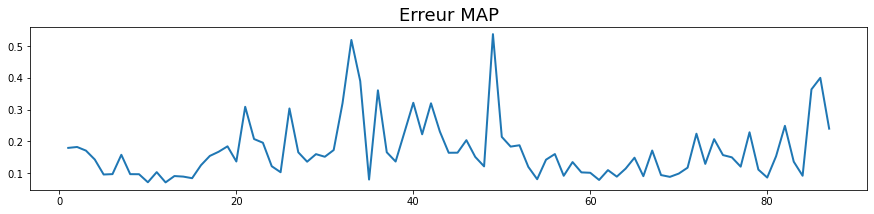

In [38]:
# Modelisation lineaire systématique sur les périodes k

# Nombre de periodes passées, ie historique utilise
h = 4
E2_lr = []
E1_lr = []
Cor_lr = []

# Toutes les prévisions de Période_Max à (Periode moins historique)
for i in range(n-h-1):
    k = i + 1

    # Données TEST et TRAIN
    y_train = df_charge.iloc[:, k]
    x_train = pd.concat([df_charge.iloc[:, (k+1):(k+h+1)],
                     df_temp.iloc[:, (k+1):(k+h+1)]], axis=1) 
    y_test = df_charge.iloc[:, (k-1)]
    x_test = pd.concat([df_charge.iloc[:, k:(k+h)],
                     df_temp.iloc[:, k:(k+h)]], axis=1) 
                     
    # Modélisation
    x_test.columns = x_train.columns
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    
    # Performances
    err2 = mean_squared_error( pred[debut:fin], y_test[debut:fin]) ** 0.5
    mape = (abs(( pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin],  pred[debut:fin])
    Cor_lr.append(cor[0]) 
    E2_lr.append(err2)
    E1_lr.append(mape)
    

#########
# Résultats
from statistics import mean

# Cath_Warning : pourquoi on ne plot que l'erreur l1 et pas l2 ou Correlation?
plt.figure(figsize=(15, 3))
x = np.linspace(1, len(E1_lr), len(E1_lr))
plt.plot(x, E1_lr, label="erreur", lw=2)
plt.title('Erreur MAP', fontsize=18)

print("RMSE: %.4f" % mean(E2_lr))
print("MAPE: %.4f" % mean(E1_lr))
print("Corr: %.4f" % mean(Cor_lr))

### Exercice 7
Avec le code ci-dessus, faites varier $h$ et choisissez l'historique le mieux adapté à l'ensemble des périodes.

In [37]:
# your answer

### Réponse 

Pour $h$ variant entre 4 et 6, on obtient des erreurs moyennes très similaires (ça se dégrade un peu pour $h=3$ et pour $h=7$).

## Modèle XGBOOST

**Cath_Warning** : j'ai viré XGB


## Modèle de Gradient Boosting

À l'aide du module `lightgbm` et de la fonction `LGBMRegressor` vous allez utiliser le boosting pour apprendre la relation entre une courbe de charge $C_k$ à une période $k$ fixée, et l'historique des courbes précédentes $C_{k+1},\dots C_{k+h+1}$ et des températures précédentes $T_{k+1},\dots T_{k+h+1}$.

**C'est du gradient boosting**


### Exercice 8 
- Commencez par fixer (arbitrairement) les paramètres de l'algorithme. Vous ferez attention à l'option `num_leaves`de `LGBMRegressor`. Cette option indique le nombre maximal de feuilles des arbres utilisés. Il est important de régler convenablement ce paramètre `num_leaves` plutôt que le paramètre `max_depth`.
- Entraînez le modèle et faites la prédiction de la même façon qu'à l'exercice 6 ci-dessus. En particulier, vous présenterez les mêmes graphiques et les mêmes calculs d'erreurs. 
- Faites varier les paramètres de l'algorithme pour essayer de diminuer les erreurs. La notion d'importance des variables permet d'indiquer les variables dont l'absence dégraderait la qualité de l'ajustement du modèle. XXX PLUS D'INFOS ICIXXX
- Enfin, évaluez la qualité de la méthode en utilisant toutes les valeurs de $k$ possibles (selon la longueur des données dont on dispose).
- dernière étape (OU EXO SUIVANT ???) Les paramètres de la méthode sont choisis par validation croisée. 


In [38]:
# Your answer

### Réponse

In [39]:
# Minimum à relancer pour la suite quand ton kernel est mort
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import datetime

path_data = 'data/'
df = pd.read_csv(os.path.join(path_data, 'Courbes_Charge08.csv'), sep=';', 
                 parse_dates=['DATE_LOCAL'],
                 decimal=',',  # les décimales sont codées par une virgule
                 dayfirst=True,
                 infer_datetime_format=True)
df.columns = [x.lower() for x in df.columns]

periode = 7 # Ou sur des consommations hebdomadaires
nobs = periode * 6 * 24
n = int(df.shape[0] / nobs)

def n_days_in_year(year):
    d1 = datetime.date(year, 1, 1) 
    d2 = datetime.date(year + 1, 1, 1) 
    return (d2 - d1).days
min_year = df['date_local'].dt.year.min()
def day_number(t):
    n_days = 0
    for y in range(min_year, t.year):
        n_days += n_days_in_year(y)       
    return n_days + t.dayofyear
col_jour = df['date_local'].apply(day_number)
df.insert(loc=0, column='jour', value=col_jour)
day_name = df['date_local'].dt.day_name()
df.insert(loc=1, column='type_jour', value=day_name)
day_num = df['date_local'].dt.dayofweek
df.insert(loc=2, column='code_jour', value=day_num)

kill = df.shape[0] - n * nobs
df2 = df.iloc[kill:df.shape[0]]

nom = ['C' + str(i) for i in range(2, n + 2)]
debut, fin = 0, nobs 
df_charge = df2.iloc[debut:fin, 4].to_frame()
for i in range(n - 1):
    debut += nobs
    fin += nobs
    a = df2.iloc[debut:fin, 4]
    df_charge.insert(0, nom[i], a.values)
df_charge.rename(columns={'charge_id08': 'C1'}, inplace=True)

nom = ['T' + str(i) for i in range(2, n + 2)]
debut, fin = 0, nobs 
df_temp = df2.iloc[debut:fin, 5].to_frame()
for i in range(n - 1):
    debut += nobs
    fin += nobs
    a = df2.iloc[debut:fin, 5]
    df_temp.insert(0, nom[i], a.values)
df_temp.rename(columns={'temp_id08': 'T1'}, inplace=True)

In [40]:
# Modelisation LightGBM

# Choisir k numero de periode
# Apprendre le lien entre C_k et son passe
# Prevoir C_{k-1}

import lightgbm as lgb

# Numero de colonne du debut la periode d'apprentissage 
k = 52
# Historique utilisé 
# CATH_WARNING : mais pourquoi il avait h=20 ?!
h = 3

# Creation du modele
gbm = lgb.LGBMRegressor(objective='regression', # default value
                        num_leaves=10, # Cath-Warning c'est pas des souches??? Default 31
                        learning_rate=0.05, # default is 0.1
                        feature_fraction = 0.2, #Use feature sub-sampling by set feature_fraction
                        bagging_fraction = 1, # XXXX la valeur par defaut est surement 1
                        n_estimators=100 #number of boosting iterations performed.
                       ) 
#gbm = lgb.LGBMRegressor()
y_train = df_charge.iloc[:, k]
x_train = pd.concat([df_charge.iloc[:, (k+1):(k+h+1)],
                     df_temp.iloc[:, (k+1):(k+h+1)]], axis=1)

y_test = df_charge.iloc[:, (k-1)]
x_test = pd.concat([df_charge.iloc[:, k:(k+h)],
                    df_temp.iloc[:, k:(k+h)]], axis=1)
x_test.columns = x_train.columns


In [41]:
# c'est là que le kernel meurt
gbm.fit(x_train, y_train)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


LGBMRegressor(bagging_fraction=1, feature_fraction=0.2, learning_rate=0.05,
              num_leaves=10, objective='regression')

In [1]:
pred = gbm.predict(x_test)

mse = mean_squared_error(y_test, pred) ** 0.5 # racine carrée de l'erreur quadratique
print("MSE: %.4f" % mse)
map1 = (abs((pred - y_test) / y_test)).mean()
print("MAPE: %.4f" % map1)
cor = pearsonr(y_test, pred)
print("Correlation observation/prevue: %.4f" % cor[0])


fig = plt.figure(figsize=(15, 3))
x = np.linspace(1, nobs, nobs)
plt.plot(x, y_test, label="observation", lw=2)
plt.plot(x, pred, label="prévision", lw=2)
plt.title('Courbes de charge', fontsize=18)
plt.legend(fontsize=14)
plt.show()

NameError: name 'gbm' is not defined

### Recherche des variables les plus "pertinentes" 

In [ ]:
# Importance des variables explicatives
var_importance = gbm.feature_importances_
var_importance = 100.0 * (var_importance / var_importance.sum())
sorted_idx = np.argsort(var_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(15, 15))
plt.barh(pos, var_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Détermination des 'meilleurs' paramètres par validation croisée sur une grille

In [ ]:
from sklearn.model_selection import GridSearchCV

estimator = lgb.LGBMRegressor()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 75, 100],
    'num_leaves' : [3, 4, 5, 6, 7]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)

gbm.fit(X_train, y_train)

print('Les meilleurs paramètres sur la grille sont ', gbm.best_params_)

In [ ]:
# Modelisation LightGBM
# Systematique
gap = 1
horizon = 3 
debut = gap*6*24
fin = debut + horizon*6*24

# Apprendre le lien Pk et son passe
# Prevoir Pk+1

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=6,
                        learning_rate=0.05,
                        feature_fraction=0.3,
                        bagging_fraction=1,
                        n_estimators=100)

# Nombre de jours passes: historique utilise
p = 20
E2_lgbm = []
E1_lgbm = []
Kor_lgbm = []

# Toutes les prévisions du Période Max à Periode 10
for k in range(n - 30):
    K = k + 1
    y_train = df_charge.iloc[:, K]
    X_train = pd.concat([df_charge.iloc[:, (K+1):(K+p+1)],
                     df_temp.iloc[:, (K+1):(K+p+1)]], axis=1)

    y_test = df_charge.iloc[:, (K-1)]
    X_test = pd.concat([df_charge.iloc[:, K:(K+p)],
                    df_temp.iloc[:, K:(K+p)]], axis=1)

    X_test.columns = X_train.columns
    gbm.fit(X_train, y_train)
    pred = gbm.predict(X_test)
    
    err2 = mean_squared_error(pred[debut:fin], y_test[debut:fin]) ** 0.5
    map1 = (abs((pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin], pred[debut:fin])
    Cor_lgbm.append(cor[0]) 
    E2_lgbm.append(err2)
    E1_lgbm.append(map1)
    
### Résultats performances    
from statistics import mean

plt.figure(figsize=(15, 3))
x = np.linspace(1, len(E1_lgbm), len(E1_lgbm))
plt.plot(x, E1_lgbm, label="erreur", lw=2)
plt.title('Erreur MAP', fontsize=18)

print("MSE: %.4f" % mean(E2_lgbm))
print("MAP: %.4f" % mean(E1_lgbm))
print("Corr: %.4f" % mean(Cor_lgbm))

plt.show()

<a id='rf'></a>
## Forêts aléatoires 


In [ ]:
# Modelisation Random Forest

# Choisir K numero de periode
# Apprendre le lien Pk et son passe
# Prevoir Pk+1

from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

# Numero colonne du debut la periode d'apprentissage ==> K-1 à prévoir
K = 70

# Nombre de periodes passees : historique utilisé
p = 20

#creation du modele
rf = RandomForestRegressor(
    n_estimators=100, # Nombre d'arbres
    max_features=0.3, # à chaque split. c'est en % de p. par defaut sqrt(p),
    max_depth=5,      # complexité
    random_state=2,
    oob_score=True
)

y_train = df_charge.iloc[:, K]
X_train = pd.concat([df_charge.iloc[:, (K+1):(K+p+1)],
                     df_temp.iloc[:, (K+1):(K+p+1)]], axis=1)

y_test = df_charge.iloc[:, (K-1)]
X_test = pd.concat([df_charge.iloc[:, K:(K+p)],
                    df_temp.iloc[:, K:(K+p)]], axis=1)

X_test.columns = X_train.columns

rf.fit(X_train, y_train)
pred = rf.predict(X_test)

mse = mean_squared_error(y_test, pred) ** 0.5
print("MSE: %.4f" % mse)
map1 = (abs((pred - y_test) / y_test)).mean()
print("MAPE: %.4f" % map1)
cor = pearsonr(y_test, pred)
print("Correlation observation/prevue: %.4f" % cor[0])

fig = plt.figure(figsize=(15, 3))
x = np.linspace(1, nobs, nobs)
plt.plot(x, y_test, label="observation", lw=2)
plt.plot(x, pred, label="prévision", lw=2)
plt.title('Courbes de charge', fontsize=18)
plt.legend(fontsize=14, loc='upper left')
plt.show()

In [ ]:
# Modelisation RF
# Systematique
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

gap = 1
horizon = 3 
debut = gap*6*24
fin = debut + horizon*6*24

# Creation du modele
rf = RandomForestRegressor(n_estimators=50, max_features="sqrt", 
                           max_depth=3)

# Nombre de jours passes: historique utilise
p = 29
E2_rf = []
E1_rf = []
Kor_rf = []

# Toutes les prévisions du Période Max à Periode 10
for k in range(n - 30):
    K = k + 1
    y_train = df_charge.iloc[:, K]
    X_train = pd.concat([df_charge.iloc[:, (K+1):(K+p+1)],
                     df_temp.iloc[:, (K+1):(K+p+1)]], axis=1)

    y_test = df_charge.iloc[:, (K-1)]
    X_test = pd.concat([df_charge.iloc[:, K:(K+p)],
                    df_temp.iloc[:, K:(K+p)]], axis=1)

    X_test.columns = X_train.columns
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    
    err2 = mean_squared_error(pred[debut:fin], y_test[debut:fin]) ** 0.5
    map1 = (abs((pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin], pred[debut:fin])
    Kor_rf.append(cor[0]) 
    E2_rf.append(err2)
    E1_rf.append(map1)
    
# Résultats performances   
from statistics import mean

plt.figure(figsize=(15, 3))
x = np.linspace(1, len(E1_rf), len(E1_rf))
plt.plot(x, E1_rf, label="erreur", lw=2)
plt.title('Erreur MAP', fontsize=18)

print("MSE: %.4f" % mean(E2_rf))
print("MAP: %.4f" % mean(E1_rf))
print("Corr: %.4f" % mean(Kor_rf))

plt.show()

<a id='comparaison'></a>
# 5.  Comparaison de modèles 

On compare les différents modèles sur

- les erreurs moyennes : L2, MAP et corrélation
- les erreurs ponctuelles MAP
    

In [ ]:
fig = plt.figure(figsize=(15, 3))

x = np.linspace(1, len(E1_rf), len(E1_rf)) 
plt.plot(x, E1_lr, label="Regression linéaire", lw=2)
plt.plot(x, E1_rf, label="Random Forest", lw=2)
plt.plot(x, E1_xgb, label="XGboost", lw=2)
plt.plot(x, E1_lgbm, label="LightGBM", lw=2)
plt.title('Erreur MAP', fontsize=18)
plt.legend(fontsize=14, loc='upper left')

print("Reg lin : MAP %.3f" % mean(E1_lr)," MSE %.1f" % mean(E2_lr)," corr %.2f" % mean(Kor_lr))
print("XGBoost : MAP %.3f" % mean(E1_xgb)," MSE  %.1f" % mean(E2_xgb)," corr %.2f" % mean(Kor_xgb))
print("LightGBM : MAP %.3f" % mean(E1_lgbm)," MSE %.1f" % mean(E2_lgbm)," corr %.2f" % mean(Kor_lgbm))
print("Random Forest : MAP %.3f" % mean(E1_rf)," MSE %.1f" % mean(E2_rf)," corr %.2f" % mean(Kor_rf))

### On refait tourner sans les températures, pour voir l'apport de ces données "exogènes"

Les modeles sont:

- `reg` : regression lineaire
- `xg_reg` : boosting par `XGBoost`
- `gbm`: boosting par `LightGBM`
- `rf` : Random Forest

In [ ]:
gap = 1
horizon = 3 
debut = gap*6*24
fin = debut + horizon*6*24


# Nombre de jours passes: historique utilise
p = 5    

E2_lr_T = []
E1_lr_T = []
Kor_lr_T = []

E2_rf_T = []
E1_rf_T = []
Kor_rf_T = []

E2_xgb_T = []
E1_xgb_T = []
Kor_xgb_T =[]

E2_lgbm_T = []
E1_lgbm_T = []
Kor_lgbm_T = []

for k in range(n - 30):
    K = k+1
    y_train = df_charge.iloc[:, K]       
    y_test = df_charge.iloc[:, (K-1)]
    X_train = df_charge.iloc[:, (K+1):(K+p+1)]
    X_test = df_charge.iloc[:, K:(K+p)]
    X_test.columns = X_train.columns

    # Regression lineaire
    lr.fit(X_train, y_train)  
    pred = lr.predict(X_test) 
    err2 = mean_squared_error(pred[debut:fin], y_test[debut:fin]) ** 0.5
    map1 = (abs((pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin], pred[debut:fin])
    Kor_lr_T.append(cor[0])
    E2_lr_T.append(err2)
    E1_lr_T.append(map1)

    # Random Forest
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    err2 = mean_squared_error(pred[debut:fin], y_test[debut:fin]) ** 0.5
    map1 = (abs((pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin], pred[debut:fin])
    Kor_rf_T.append(cor[0])
    E2_rf_T.append(err2)
    E1_rf_T.append(map1)
    
    # XGBoost
    xg_reg.fit(X_train.to_numpy(),y_train.to_numpy())
    pred = xg_reg.predict(X_test.to_numpy())
    err2 = mean_squared_error(pred[debut:fin], y_test[debut:fin]) ** 0.5
    map1 =  (abs((pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin], pred[debut:fin])
    Kor_xgb_T.append(cor[0])
    E2_xgb_T.append(err2)
    E1_xgb_T.append(map1)

    # LightGBM
    gbm.fit(X_train, y_train)
    pred = gbm.predict(X_test)
    err2 = mean_squared_error(pred[debut:fin], y_test[debut:fin]) ** 0.5
    map1 = (abs((pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin], pred[debut:fin])
    Kor_lgbm_T.append(cor[0]) 
    E2_lgbm_T.append(err2)
    E1_lgbm_T.append(map1)

In [ ]:
fig = plt.figure(figsize=(15, 3))

x = np.linspace(1, len(E1_rf), len(E1_rf)) 
plt.plot(x, E1_lr_T, label="Regression linéaire", lw=2)
plt.plot(x, E1_rf_T, label="Random Forest", lw=2)
plt.plot(x, E1_xgb_T, label="XGboost", lw=2)
plt.plot(x, E1_lgbm_T, label="LightGBM", lw=2)
plt.title('Erreur MAP', fontsize=18)
plt.legend(fontsize=14, loc='upper left')

print("Reg lin : MAP %.3f" % mean(E1_lr_T)," MSE %.1f" % mean(E2_lr_T)," corr %.2f" % mean(Kor_lr_T))
print("XGBoost : MAP %.3f" % mean(E1_xgb_T)," MSE  %.1f" % mean(E2_xgb_T)," corr %.2f" % mean(Kor_xgb_T))
print("LightGBM : MAP %.3f" % mean(E1_lgbm_T)," MSE %.1f" % mean(E2_lgbm_T)," corr %.2f" % mean(Kor_lgbm_T))
print("Random Forest : MAP %.3f" % mean(E1_rf_T)," MSE %.1f" % mean(E2_rf_T)," corr %.2f" % mean(Kor_rf_T))

## Comparaison avec et sans les temperatures

In [ ]:
fig = plt.figure(figsize=(15, 6))

x = np.linspace(1, len(E1_rf), len(E1_rf))
plt.subplot(2, 1, 1)

plt.plot(x, E1_lr, label="Avec températures", lw=2)
plt.plot(x, E1_lr_T, label="Sans températures)", lw=2)
plt.title('Erreur MAP pour Régression Linéaire', fontsize=18)
plt.legend(fontsize=14, loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(x, E1_rf, label="Random Forest (avec temps)", lw=2)
plt.plot(x, E1_rf_T, label="Random Forest (sans temps)", lw=2)
plt.title('Erreur MAP pour Random Forest', fontsize=18)
plt.legend(fontsize=14, loc='upper left')

plt.tight_layout()